# Pre-processing - Malware labels

This notebook starts the classification process.

The first approach is to classify the samples as malware or goodware, based on the top vendors.

Before doing so, we take the top vendors and check for variation in first and last classifications, like in "Data Labeling - Choosing vendors". This allows us to re-iterate over the chosen threshold for malware (at least 5 vendors).

In [47]:
from IPython.display import display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data_folder = '../data/'
selected_vendors_file = data_folder + 'vendors_selected.csv.gz'
vendors_file = data_folder + 'vendors.csv.gz'
reports_file = data_folder + 'reports.csv.gz'
malware_file = data_folder + 'malware_samples.csv.gz'
goodware_file = data_folder + 'goodware_samples.csv.gz'

In [14]:
reports = pd.read_csv(reports_file)
reports.set_index('link', inplace=True)
reports.drop(['file_name', 'file_size', 'file_type'], axis=1, inplace=True)
reports.date = pd.to_datetime(reports.date, infer_datetime_format=True)

selected_vendors = pd.read_csv(selected_vendors_file)
selected_vendors.set_index('link', inplace=True)

reports_vendors = reports.join(selected_vendors, how='inner')

In [16]:
%%time
md5_dups = set(reports_vendors[reports_vendors.md5.duplicated()].md5)
reports_duplicated = reports_vendors[reports_vendors.md5.isin(md5_dups)]
vendors_count = reports_duplicated.replace('Clean', np.nan)
vendors_count = vendors_count.groupby(['md5', 'date']).count().sum(axis=1).reset_index('date')

# For differences in first and last submission
differences_fl = []
# Calculate the pairwise difference between reports
for md5 in vendors_count.index.unique():
    temp = vendors_count[vendors_count.index == md5].sort_values('date', ascending=False)
    count = list(temp[0])
    if sum(count) == 0:
        continue
    differences_fl += [count[0] - count[-1]]

CPU times: user 3min 19s, sys: 125 ms, total: 3min 19s
Wall time: 3min 19s


The following graph represents the proportion of differences between last and first scan, showing that the tendency is for vendors to increase the number of positive classifications (favor false negatives), rather than decreasing the number of positive classifications (favor false positives).

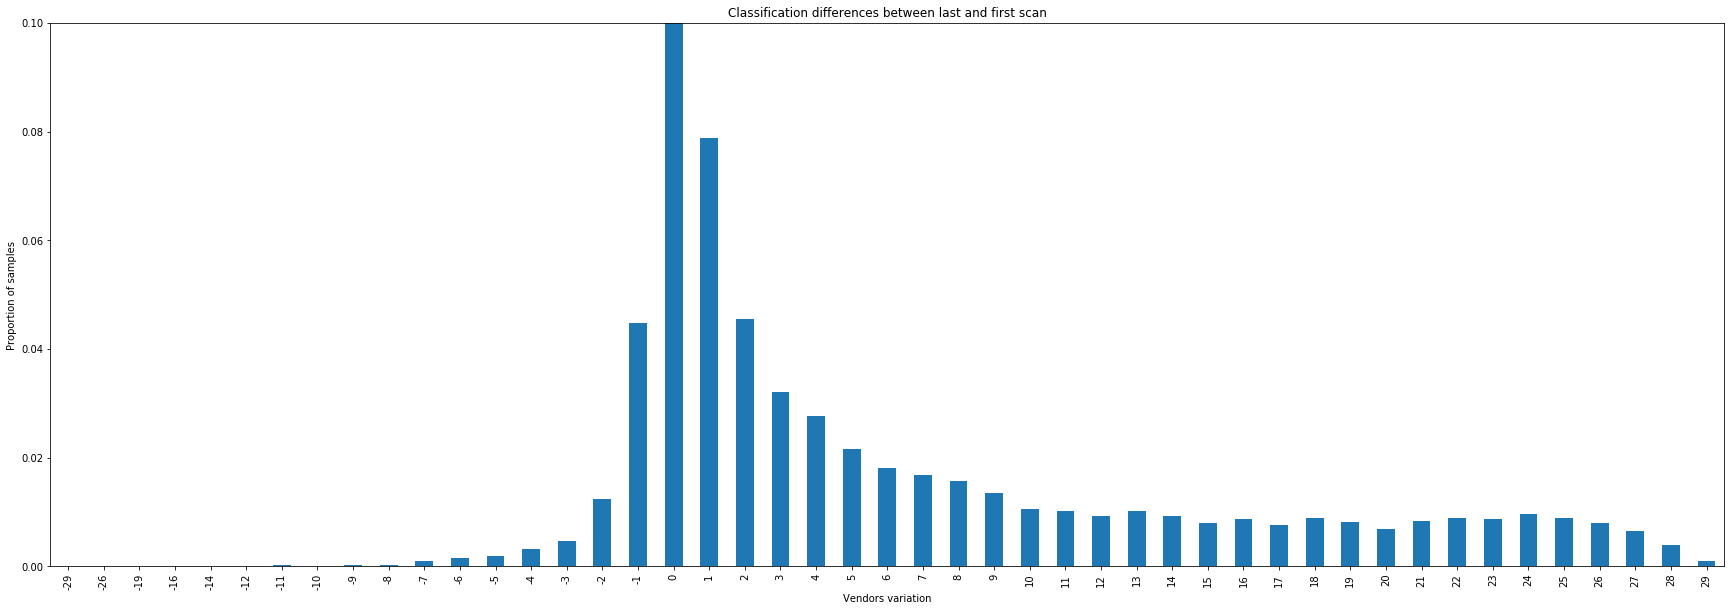

In [17]:
diff_fl_percent = pd.Series(differences_fl)
diff_fl_percent = diff_fl_percent.value_counts().sort_index().divide(len(diff_fl_percent))
ax2 = diff_fl_percent.plot.bar(figsize=((30, 10)), ylim=(0, 0.1),
                               title='Classification differences between last and first scan')
ax2.set_xlabel('Vendors variation')
ax2.set_ylabel('Proportion of samples')
plt.show()

In [35]:
display('Samples that go from 3 vendors to none: {:.2f}%'.format(
    diff_fl_percent[diff_fl_percent.index < -3].sum()*100))
display('Samples that go from 3 vendors to one: {:.2f}%'.format(
    diff_fl_percent[diff_fl_percent.index < -2].sum()*100))

'Samples that go from 3 vendors to none: 0.88%'

'Samples that go from 3 vendors to one: 1.35%'

Choosing a threshold $V=3$ gives a confidence of $1 - \sum_{n=-2}^{-\infty} P(n) = 1 - 0.0135 = 0.9865$ that a sample will not become clean (i.e. at least one vendor will still classify it as malware).

The following filters the samples into malware (if at least 3 vendors classify it as malware) and goodware (if all vendors classify it as clean)

In [13]:
reports_vendors = reports_vendors.sort_values('date').drop_duplicates(keep='last', subset='md5')
reports_vendors.replace('Clean', np.nan, inplace=True)
# Threshold is 3, + 2 for md5 and date column
malware_samples = reports_vendors[reports_vendors.count(axis=1) >= 3 + 2]
goodware_samples = reports_vendors[reports_vendors.count(axis=1) == 2]

In [46]:
display('Malware samples: {}'.format(len(malware_samples)))
display('Goodware samples: {}'.format(len(goodware_samples)))

'Malware samples: 169830'

'Goodware samples: 44719'

In [48]:
malware_samples.to_csv(malware_file, compression='gzip')
goodware_samples.to_csv(goodware_file, compression='gzip')

Create the train and test dataset such that the number of malware and goodware is balanced.

In [70]:
upper_limit = len(goodware_samples) if len(goodware_samples) < len(malware_samples) else len(malware_samples)
test_size = 0.25
train_size = 1 - test_size

malware_train = pd.DataFrame(malware_samples[:int(upper_limit * train_size)].index)
malware_train['malware'] = 1
malware_train.set_index('link', inplace=True)
goodware_train = pd.DataFrame(goodware_samples[:int(upper_limit * train_size)].index)
goodware_train['malware'] = 0
goodware_train.set_index('link', inplace=True)
train = pd.concat([malware_train, goodware_train])

malware_test = pd.DataFrame(malware_samples[int(upper_limit * train_size):
                                            int(upper_limit * train_size) + int(upper_limit * test_size)].index)
malware_test['malware'] = 1
malware_test.set_index('link', inplace=True)
goodware_test = pd.DataFrame(goodware_samples[int(upper_limit * train_size):
                                              int(upper_limit * train_size) + int(upper_limit * test_size)].index)
goodware_test['malware'] = 0
goodware_test.set_index('link', inplace=True)
test = pd.concat([malware_test, goodware_test])